# Classifying with unhealthy CpGs

- This workbook trains the linear, lasso and ridge regression models for the Alzheimer's and Huntington's cohorts using the CpGs in the top 100 for each of these cohorts that were also present in the unhealthy data

- For Alzheimer's cohort this notebook runs 2 classifiers

1. Using residual values from Alzheimer's model and age to classify healthy vs. Alzheimers

2. Using the Alzheimer's top 100 CpGs (which are also in unhealthy dataset) to classify healthy vs. Alzheimers

In [3]:
import _pickle as cPickle
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from math import sqrt
from xgboost import XGBRegressor
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score

### Reading in data

In [4]:
data_df=pd.read_csv('combined_healthy_unhealthy_107_cpgs.csv',index_col=0)  
data_df=data_df[data_df['AGE']>=20]
data_df=data_df[data_df['AGE']<=100]

### Huntington's

- Getting huntingtons_df which contains CpG sites in top 100 for Huntingston's and available in the HC and Alzheimer's datasets

In [5]:
#Hunt=2
#Alz=1
huntingtons_df=data_df[data_df['status']==2]
huntingtons_df=huntingtons_df.drop(columns=['status'])

with open(r"../huntingtons/xgb_hunt_brain_cpgs", "rb") as input_file:
    hunt_brain_top_cpgs = cPickle.load(input_file)
xgb_hunt_brain_top_cpgs=list(hunt_brain_top_cpgs)

top_107_cpgs=list(huntingtons_df.columns)[1:]
hunt_drop=[]
for i in top_107_cpgs:
    if i not in xgb_hunt_brain_top_cpgs[0:100]:
        hunt_drop.append(i)
        
huntingtons_df=huntingtons_df.drop(columns=hunt_drop)
huntingtons_df

,AGE,cg06645033,cg12100751,cg17104258,cg24851854,cg05167251,cg23606718,cg24079702,cg16703882,cg02891686,...,cg14611683,cg15393490,cg19622662,cg23813012,cg02375320,cg03545227,cg05318142,cg14674720,cg19451698,cg04834794
GSM1871451,83.0,0.365,0.145,0.179,0.236,0.071,0.159,0.308,0.185,0.564,...,0.439,0.167,0.147,0.088,0.093,0.169,0.179,0.124,0.096,0.078
GSM1871457,48.0,0.226,0.119,0.173,0.178,0.042,0.112,0.190,0.112,0.506,...,0.380,0.299,0.158,0.079,0.059,0.142,0.101,0.054,0.048,0.030
GSM1871498,51.0,0.239,0.150,0.244,0.229,0.046,0.168,0.245,0.154,0.446,...,0.362,0.263,0.210,0.070,0.021,0.160,0.079,0.084,0.047,0.049
GSM1871545,65.0,0.317,0.163,0.178,0.254,0.085,0.178,0.243,0.144,0.461,...,0.412,0.328,0.146,0.135,0.088,0.211,0.064,0.079,0.077,0.051
GSM1871590,67.0,0.293,0.164,0.189,0.225,0.074,0.160,0.245,0.180,0.595,...,0.444,0.270,0.174,0.159,0.038,0.179,0.191,0.083,0.056,0.040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM1871815,56.0,0.187,0.132,0.175,0.179,0.043,0.140,0.173,0.140,0.500,...,0.329,0.237,0.077,0.092,0.081,0.106,0.017,0.064,0.038,0.025
GSM1871849,62.0,0.210,0.148,0.044,0.236,0.043,0.147,0.215,0.152,0.534,...,0.284,0.243,0.062,0.131,0.101,0.149,0.020,0.104,0.044,0.063
GSM1871852,58.0,0.226,0.163,0.212,0.207,0.072,0.130,0.182,0.150,0.529,...,0.263,0.227,0.159,0.102,0.089,0.129,0.033,0.097,0.048,0.043
GSM1871860,91.0,0.278,0.166,0.017,0.238,0.063,0.176,0.238,0.183,0.567,...,0.434,0.196,0.055,0.143,0.103,0.196,0.014,0.087,0.060,0.057


### Alzheimer's

- Getting alzheimers_df which contains CpG sites in top 100 for Huntingston's and available in the HC and Alzheimer's datasets

In [6]:
alzheimers_df=data_df[data_df['status']==1]
alzheimers_df=alzheimers_df.drop(columns=['status'])

with open(r"../alzheimers/xgb_alz_brain_cpgs", "rb") as input_file:
    alz_brain_top_cpgs = cPickle.load(input_file)
xgb_alz_brain_top_cpgs=list(alz_brain_top_cpgs)

top_107_cpgs=list(alzheimers_df.columns)[1:]
alz_drop=[]
for i in top_107_cpgs:
    if i not in xgb_alz_brain_top_cpgs[0:100]:
        alz_drop.append(i)
        
alzheimers_df=alzheimers_df.drop(columns=alz_drop)
alzheimers_df

,AGE,cg01066472,cg17104258,cg20144008,cg27009691,cg06782035,cg13954457,cg26600753,cg16875032,cg13407463,...,cg04897644,cg11236550,cg15393490,cg15731815,cg17801546,cg23813012,cg25139493,cg01812045,cg21182694,cg00760935
GSM1068826,88.0,0.512,0.010,0.165,0.648,0.035,0.024,0.906,0.011,0.929,...,0.782,0.026,0.065,0.169,0.013,0.041,0.082,0.267,0.243,0.174
GSM1068827,92.0,0.519,0.015,0.198,0.584,0.033,0.022,0.937,0.011,0.892,...,0.770,0.019,0.064,0.187,0.018,0.040,0.108,0.248,0.265,0.201
GSM1068829,93.0,0.620,0.024,0.232,0.635,0.031,0.020,0.904,0.164,0.909,...,0.859,0.028,0.068,0.226,0.025,0.052,0.063,0.264,0.329,0.238
GSM1068832,96.0,0.549,0.019,0.257,0.673,0.034,0.014,0.926,0.179,0.927,...,0.860,0.040,0.036,0.187,0.019,0.036,0.045,0.251,0.317,0.121
GSM1068833,86.0,0.287,0.021,0.196,0.633,NaN,0.022,0.928,0.224,0.930,...,0.735,0.028,0.053,0.125,0.016,0.051,0.061,0.219,0.236,0.209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM2809060,80.0,0.635,0.189,0.288,0.674,0.213,0.060,0.857,0.318,0.957,...,0.860,0.083,0.127,0.134,0.184,0.158,0.081,0.223,0.184,0.302
GSM2809061,70.0,0.520,0.394,0.303,0.685,0.103,0.072,0.725,0.270,0.867,...,0.710,0.268,0.213,0.137,0.373,0.144,0.069,0.179,0.214,0.223
GSM2809062,75.0,0.321,0.134,0.285,0.696,0.076,0.086,0.817,0.440,0.938,...,0.790,0.054,0.204,0.087,0.138,0.136,0.067,0.216,0.209,0.239
GSM2809063,79.0,0.537,0.143,0.277,0.693,0.101,0.074,0.842,0.386,0.866,...,0.835,0.068,0.147,0.137,0.161,0.211,0.092,0.232,0.220,0.309


### Healthy

- Getting healthy_huntingtons_df which is the healthy control data with CpG sites in top 100 for Huntingtons

In [7]:
healthy_huntingtons_df=data_df[data_df['status']==0]
healthy_huntingtons_df=healthy_huntingtons_df.drop(columns=['status'])

with open(r"../huntingtons/xgb_hunt_brain_cpgs", "rb") as input_file:
    hunt_brain_top_cpgs = cPickle.load(input_file)
xgb_hunt_brain_top_cpgs=list(hunt_brain_top_cpgs)

top_107_cpgs=list(healthy_huntingtons_df.columns)[1:]
hunt_drop=[]
for i in top_107_cpgs:
    if i not in xgb_hunt_brain_top_cpgs[0:100]:
        hunt_drop.append(i)
        
healthy_huntingtons_df=healthy_huntingtons_df.drop(columns=hunt_drop)
healthy_huntingtons_df

,AGE,cg06645033,cg12100751,cg17104258,cg24851854,cg05167251,cg23606718,cg24079702,cg16703882,cg02891686,...,cg14611683,cg15393490,cg19622662,cg23813012,cg02375320,cg03545227,cg05318142,cg14674720,cg19451698,cg04834794
GSM2139432,71.0000,0.245,0.116,0.106,0.204,0.059,0.158,0.214,0.201,0.577,...,0.384,0.226,0.088,0.194,0.095,0.221,0.026,0.136,0.102,0.124
GSM2139249,76.0000,0.309,0.174,0.101,0.287,0.057,0.153,0.300,0.233,0.531,...,0.415,0.235,0.095,0.175,0.130,0.207,0.029,0.150,0.064,0.084
GSM1069208,40.0000,0.159,0.090,0.250,0.168,0.057,0.085,0.144,0.150,0.448,...,0.339,0.271,0.232,0.089,0.081,0.126,0.037,0.108,0.044,0.023
GSM1443489,40.0000,0.159,0.090,0.250,0.168,0.057,0.085,0.144,0.150,0.448,...,0.339,0.271,0.232,0.089,0.081,0.126,0.037,0.108,0.044,0.023
GSM1069141,59.0000,0.186,0.154,0.096,0.188,0.074,0.168,0.267,0.206,0.449,...,0.335,0.301,0.080,0.111,0.084,0.181,0.019,0.102,0.054,0.076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM1871753,53.0000,0.226,0.143,0.216,0.191,0.042,0.151,0.064,0.131,0.551,...,0.358,0.218,0.194,0.103,0.080,0.125,0.014,0.058,0.038,0.048
GSM1438255,53.1594,0.171,0.122,0.289,0.142,0.042,0.145,0.168,0.131,0.459,...,0.255,0.333,0.236,0.071,0.073,0.107,0.042,0.045,0.022,0.036
GSM1438138,53.3855,0.261,0.176,0.292,0.255,0.040,0.161,0.224,0.169,0.513,...,0.290,0.254,0.233,0.134,0.093,0.204,0.065,0.127,0.029,0.053
GSM1438147,53.4770,0.215,0.147,0.196,0.227,0.048,0.162,0.203,0.145,0.586,...,0.298,0.321,0.226,0.155,0.108,0.210,0.092,0.097,0.060,0.074


- Getting healthy_alzheimers_df which is the healthy control data with CpG sites in top 100 for Alzheimer's

In [8]:
healthy_alzheimers_df=data_df[data_df['status']==0]
healthy_alzheimers_df=healthy_alzheimers_df.drop(columns=['status'])

with open(r"../alzheimers/xgb_alz_brain_cpgs", "rb") as input_file:
    alz_brain_top_cpgs = cPickle.load(input_file)
xgb_alz_brain_top_cpgs=list(alz_brain_top_cpgs)

top_107_cpgs=list(healthy_alzheimers_df.columns)[1:]
alz_drop=[]
for i in top_107_cpgs:
    if i not in xgb_alz_brain_top_cpgs[0:100]:
        alz_drop.append(i)
        
healthy_alzheimers_df=healthy_alzheimers_df.drop(columns=alz_drop)
healthy_alzheimers_df

,AGE,cg01066472,cg17104258,cg20144008,cg27009691,cg06782035,cg13954457,cg26600753,cg16875032,cg13407463,...,cg04897644,cg11236550,cg15393490,cg15731815,cg17801546,cg23813012,cg25139493,cg01812045,cg21182694,cg00760935
GSM2139432,71.0000,0.331,0.106,0.313,0.604,0.087,0.071,0.869,0.250,0.940,...,0.676,0.106,0.226,0.139,0.157,0.194,0.090,0.237,0.240,0.248
GSM2139249,76.0000,0.378,0.101,0.352,0.597,0.090,0.105,0.766,0.297,0.940,...,0.695,0.087,0.235,0.124,0.162,0.175,0.066,0.230,0.215,0.245
GSM1069208,40.0000,0.452,0.250,0.209,0.707,0.057,0.046,0.780,0.353,0.936,...,0.801,0.314,0.271,0.057,0.338,0.089,0.047,0.238,0.193,0.276
GSM1443489,40.0000,0.452,0.250,0.209,0.707,0.057,0.046,0.780,0.353,0.936,...,0.801,0.314,0.271,0.057,0.338,0.089,0.047,0.238,0.193,0.276
GSM1069141,59.0000,0.358,0.096,0.216,0.714,0.073,0.049,0.821,0.277,0.959,...,0.697,0.082,0.301,0.098,0.143,0.111,0.060,0.239,0.219,0.252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM1871753,53.0000,0.498,0.216,0.572,0.748,0.057,0.062,0.863,0.429,0.973,...,0.934,0.168,0.218,0.073,0.224,0.103,0.040,0.227,0.201,0.295
GSM1438255,53.1594,0.510,0.289,0.403,0.748,0.088,0.034,0.794,0.273,0.958,...,0.741,0.237,0.333,0.050,0.280,0.071,0.036,0.201,0.172,0.274
GSM1438138,53.3855,0.329,0.292,0.426,0.702,0.149,0.104,0.841,0.032,0.943,...,0.738,0.209,0.254,0.094,0.305,0.134,0.061,0.232,0.188,0.273
GSM1438147,53.4770,0.466,0.196,0.384,0.727,0.192,0.070,0.840,0.372,0.953,...,0.881,0.192,0.321,0.095,0.272,0.155,0.048,0.268,0.220,0.334


In [9]:
#Function to apply 'model' to data X and make predictions 
#X: data with correct CpG ordering
#y: true tables
#mod_name: string e.g. 'Linear Regression'
#group: cohort name - string - e.g. 'Huntingtons'
def apply_model_and_plot(model,X,y,mod_name,group):

    # Make predictions and evaluate
    preds_y = model.predict(X)
    rms = sqrt(mean_squared_error(y, preds_y))
    r2 = r2_score(y, preds_y)
    mae = mean_absolute_error(y,preds_y)

    # Plot 

    plt.scatter(y, preds_y, alpha=0.5)
    plt.plot(range(0,120), range(0,120), c='red')
    plt.xlabel('True Age')
    plt.ylabel('Predicted Age')
    plt.grid(True, lw=1.5, ls='--', alpha=0.75)
    plt.title(str(mod_name)+' on '+str(group))
    #a='rMSE:'+str(round(rms,3))
    b='MAE:'+str(round(mae,3))
    #plt.text(80, 15,'$%s$'%a,fontsize='large')
    plt.text(80, 1,'$%s$'%b,fontsize='large')
    plt.xlim((0,120))
    plt.ylim((0,175))
    plt.show()

    # print metric
    print(f'rMSE:{rms:.3f} years')
    print(f'r^2:{r2:.3f}')


### Defining the models

In [10]:
def lassoCV_regress(X_train,  X_test, y_train,y_test, plot=True, xmin=0,xmax=120,alphas=[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5],cv=5):

    #Build fit model
    mod = mod = LassoCV(alphas=alphas,cv=cv)
    mod.fit(X_train, y_train)
    
    # Make predictions and evaluate
    preds_train = mod.predict(X_train)
    preds_test = mod.predict(X_test)
    rms_train = (mean_squared_error(y_train, preds_train))**0.5
    rms_test = (mean_squared_error(y_test, preds_test))**0.5
    r2_train = r2_score(y_train, preds_train)
    r2_test = r2_score(y_test, preds_test)
    mae_test = mean_absolute_error(y_test,preds_test)
    
    # Plot final true vs predicted age
    if plot:
        fig, ax = plt.subplots(1,2, figsize=(15,4))
        ax[1].scatter(y_train, preds_train, alpha=0.5)
        ax[1].plot(range(xmin,xmax), range(xmin,xmax), c='red')
        ax[1].set_xlabel('True Age')
        ax[1].set_ylabel('Predicted Age')
        ax[1].set_xlim((0,120))
        ax[1].set_ylim((0,120))
        ax[1].grid(True, lw=1.5, ls='--', alpha=0.75)
    

        ax[1].set_title('Lasso Regression on training data')
        

        ax[0].scatter(y_test, preds_test, alpha=0.5)
        ax[0].plot(range(xmin,xmax), range(xmin,xmax), c='red')
        ax[0].set_xlabel('True Age')
        ax[0].set_ylabel('Predicted Age')
        ax[0].grid(True, lw=1.5, ls='--', alpha=0.75)
        b='MAE:'+str(round(mae_test,3))
        ax[0].text(80, 1,'$%s$'%b,fontsize='large')
        ax[0].set_xlim((0,120))
        ax[0].set_ylim((0,120))
        ax[0].set_title('Lasso Regression on testing data')
        plt.show()
    
    # print metric
    print(f'The rms on the training data is {rms_train:.3f} years')
    print(f'The rms on the testing data is {rms_test:.3f} years')
    print(f'The r^2 on the training data is {r2_train:.3f}')
    print(f'The r^2 on the testing data is {r2_test:.3f}')
    
    return mod

In [11]:
def linear_regress(X_train,  X_test, y_train, y_test, plot=True,xmin=0,xmax=120):
    
    #Build fit model
    mod = LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs='None')
    mod.fit(X_train, y_train)
    
    # Make predictions and evaluate
    preds_train = mod.predict(X_train)
    preds_test = mod.predict(X_test)
    rms_train = sqrt(mean_squared_error(y_train, preds_train))
    rms_test = sqrt(mean_squared_error(y_test, preds_test))
    r2_train = r2_score(y_train, preds_train)
    r2_test = r2_score(y_test, preds_test)
    mae_test = mean_absolute_error(y_test,preds_test)
    
    # Plot progress over epochs and final true vs predicted age
    if plot:
        fig, ax = plt.subplots(1,2, figsize=(15,4))
        ax[1].scatter(y_train, preds_train, alpha=0.5)
        ax[1].plot(range(xmin,xmax), range(xmin,xmax), c='red')
        ax[1].set_xlabel('True Age')
        ax[1].set_ylabel('Predicted Age')
        ax[1].grid(True, lw=1.5, ls='--', alpha=0.75)
        ax[1].set_title('Linear Regression on training data')
        ax[1].set_xlim((0,120))
        ax[1].set_ylim((0,120))

        ax[0].scatter(y_test, preds_test, alpha=0.5)
        ax[0].plot(range(xmin,xmax), range(xmin,xmax), c='red')
        ax[0].set_xlabel('True Age')
        ax[0].set_ylabel('Predicted Age')
        ax[0].grid(True, lw=1.5, ls='--', alpha=0.75)
        b='MAE:'+str(round(mae_test,3))
        ax[0].text(80, 1,'$%s$'%b,fontsize='large')
        ax[0].set_title('Linear Regression on testing data')
        ax[1].set_xlim((0,120))
        ax[1].set_ylim((0,120))
        plt.show()
    
    # print metric
    print(f'The rms on the training data is {rms_train:.3f} years')
    print(f'The rms on the testing data is {rms_test:.3f} years')
    print(f'The r^2 on the training data is {r2_train:.3f}')
    print(f'The r^2 on the testing data is {r2_test:.3f}')
    
    return mod

In [12]:
def ridge_regress(X_train,  X_test, y_train,y_test, plot=True, xmin=0,xmax=120,alphas=[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5],cv=5):

    #Build fit model
    mod = Ridge()
    mod.fit(X_train, y_train)
    
    # Make predictions and evaluate
    preds_train = mod.predict(X_train)
    preds_test = mod.predict(X_test)
    rms_train = (mean_squared_error(y_train, preds_train))**0.5
    rms_test = (mean_squared_error(y_test, preds_test))**0.5
    r2_train = r2_score(y_train, preds_train)
    r2_test = r2_score(y_test, preds_test)
    mae_test = mean_absolute_error(y_test,preds_test)
    
    # Plot final true vs predicted age
    if plot:
        fig, ax = plt.subplots(1,2, figsize=(15,4))
        ax[1].scatter(y_train, preds_train, alpha=0.5)
        ax[1].plot(range(xmin,xmax), range(xmin,xmax), c='red')
        ax[1].set_xlabel('True Age')
        ax[1].set_ylabel('Predicted Age')
        ax[1].grid(True, lw=1.5, ls='--', alpha=0.75)
        ax[1].set_xlim((0,120))
        ax[1].set_ylim((0,120))
        ax[1].set_title('Ridge Regression on training data')

        ax[0].scatter(y_test, preds_test, alpha=0.5)
        ax[0].plot(range(xmin,xmax), range(xmin,xmax), c='red')
        ax[0].set_xlabel('True Age')
        ax[0].set_ylabel('Predicted Age')
        ax[0].grid(True, lw=1.5, ls='--', alpha=0.75)
        b='MAE:'+str(round(mae_test,3))
        ax[0].text(80, 1,'$%s$'%b,fontsize='large')
        ax[0].set_xlim((0,120))
        ax[0].set_ylim((0,120))
        ax[0].set_title('Ridge Regression on testing data')
        plt.show()
    
    # print metric
    print(f'The rms on the training data is {rms_train:.3f} years')
    print(f'The rms on the testing data is {rms_test:.3f} years')
    print(f'The r^2 on the training data is {r2_train:.3f}')
    print(f'The r^2 on the testing data is {r2_test:.3f}')
    
    return mod

In [13]:
def mean_impute(data):
    nas=data.isnull().sum()    
    col_means=data.mean(axis=0)
    na_cols=[]
    na_cols_means=[]

    for i in range(len(nas)):
        if nas[i]!=0:        
            na_cols.append(nas.keys()[i])
            na_cols_means.append(col_means[i])
        
    ids=list(data.index)
    for i in ids:
        for j in range(len(na_cols)):
            if str(data.loc[i][na_cols[j]])=="nan":
                data.loc[i][na_cols[j]]=na_cols_means[j]
    
    
    return data

## Alzheimer's

### Working/heldout data split

In [14]:
#Reading in test/train split IDs
with open(r"../train_test_ids/brain_alz_working_ids", "rb") as input_file:
    brain_alz_working_ids = cPickle.load(input_file)
with open(r"../train_test_ids/brain_alz_held_out_ids", "rb") as input_file:
    brain_alz_held_out_ids = cPickle.load(input_file)

In [15]:
#Getting working and heldout dataframes 
alz_working=alzheimers_df
alz_heldout=alzheimers_df
all_alz_id=list(alzheimers_df.index)
for i in all_alz_id:
    if i not in brain_alz_working_ids:
        alz_working=alz_working.drop([i])
    if i not in brain_alz_held_out_ids:
        alz_heldout=alz_heldout.drop([i])

In [16]:
#X and y split for working and held out data
X_held_out_alz=alz_heldout.iloc[:, 1:]
Y_held_out_alz=alz_heldout[['AGE']]
X_held_out_alz=mean_impute(X_held_out_alz)
X_work_alz=alz_working.iloc[:, 1:]
Y_work_alz=alz_working[['AGE']]

### Test-train split

In [17]:
#Train-test split for working data
X_train_alz, X_test_alz, Y_train_alz, Y_test_alz = train_test_split(X_work_alz, Y_work_alz, test_size=0.25, random_state = 11, shuffle=True)

In [18]:
X_train_alz=mean_impute(X_train_alz)
X_test_alz=mean_impute(X_test_alz)

In [ ]:
#Fitting models and printing train and held out results (Note: this is for the final reporting
#if doing hyperparameter tunning replace the held out data with test data)

### Linear 

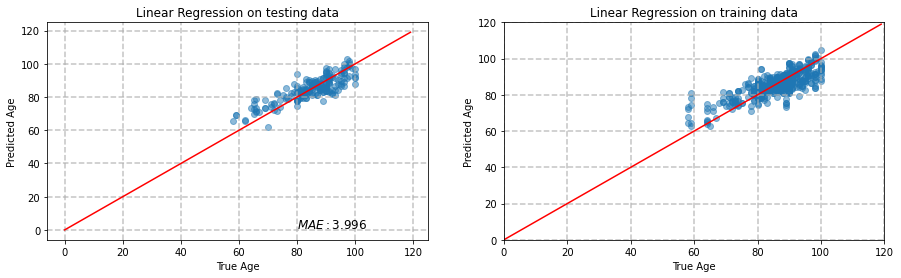

The rms on the training data is 5.427 years
The rms on the testing data is 5.037 years
The r^2 on the training data is 0.625
The r^2 on the testing data is 0.705


In [19]:
mod_55_brain_alz=linear_regress(X_train_alz, X_held_out_alz, Y_train_alz, Y_held_out_alz,xmin=0,xmax=120)

### Lasso 

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


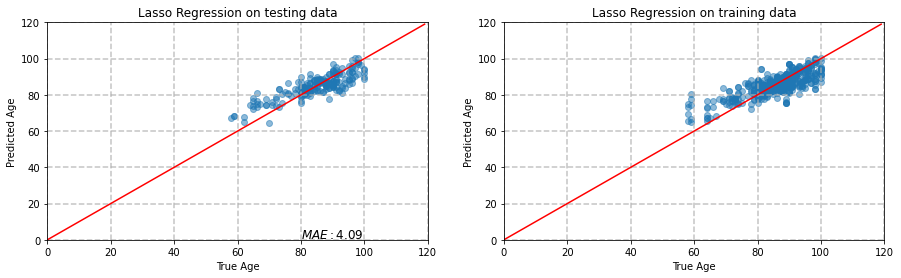

The rms on the training data is 5.543 years
The rms on the testing data is 5.201 years
The r^2 on the training data is 0.608
The r^2 on the testing data is 0.685


In [20]:
alz_lasso=lassoCV_regress(X_train_alz, X_held_out_alz, Y_train_alz, Y_held_out_alz,xmin=0,xmax=120)

### Ridge

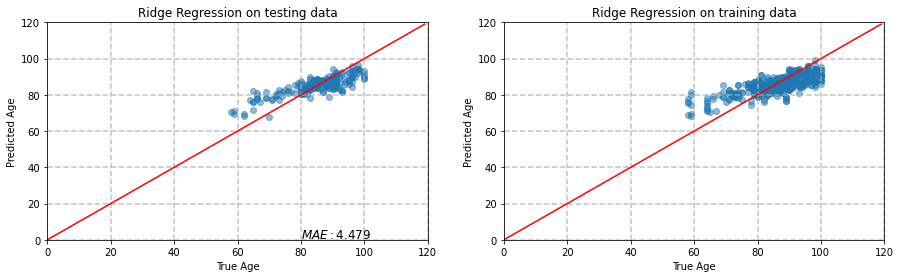

The rms on the training data is 6.081 years
The rms on the testing data is 5.752 years
The r^2 on the training data is 0.528
The r^2 on the testing data is 0.615


In [21]:
alz_ridge=ridge_regress(X_train_alz, X_held_out_alz, Y_train_alz, Y_held_out_alz,xmin=0,xmax=120)

### Applying unhealthy model to healthy

In [22]:
X_healthy_alz = healthy_alzheimers_df.iloc[:, 1:]
y_healthy_alz = healthy_alzheimers_df[['AGE']]
X_healthy_alz = mean_impute(X_healthy_alz)

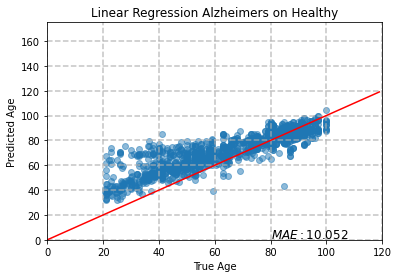

rMSE:13.382 years
r^2:0.594


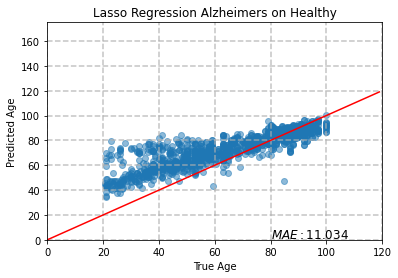

rMSE:14.699 years
r^2:0.510


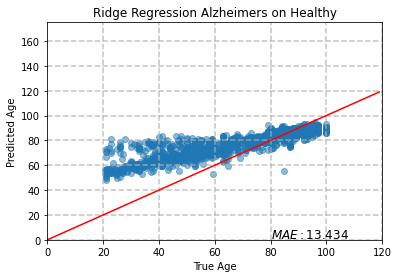

rMSE:17.689 years
r^2:0.291


In [23]:
apply_model_and_plot(mod_55_brain_alz,X_healthy_alz,y_healthy_alz,'Linear Regression Alzheimers','Healthy')
apply_model_and_plot(alz_lasso,X_healthy_alz,y_healthy_alz,'Lasso Regression Alzheimers','Healthy')
apply_model_and_plot(alz_ridge,X_healthy_alz,y_healthy_alz,'Ridge Regression Alzheimers','Healthy')

## Huntington's

In [24]:
### Working/heldout data split
with open(r"../train_test_ids/brain_hunt_working_ids", "rb") as input_file:
    brain_hunt_working_ids = cPickle.load(input_file)
with open(r"../train_test_ids/brain_hunt_held_out_ids", "rb") as input_file:
    brain_hunt_held_out_ids = cPickle.load(input_file)

In [25]:
#Getting working and heldout dataframes 
hunt_working=huntingtons_df
hunt_heldout=huntingtons_df
all_hunt_id=list(huntingtons_df.index)
for i in all_hunt_id:
    if i not in brain_hunt_working_ids:
        hunt_working=hunt_working.drop([i])
    if i not in brain_hunt_held_out_ids:
        hunt_heldout=hunt_heldout.drop([i])

In [26]:
#X and y split for working and held out data
X_held_out_hunt=hunt_heldout.iloc[:, 1:]
Y_held_out_hunt=hunt_heldout[['AGE']]
X_held_out_hunt=mean_impute(X_held_out_hunt)
X_work_hunt=hunt_working.iloc[:, 1:]
Y_work_hunt=hunt_working[['AGE']]

### Test-train split

In [27]:
X_train_hunt, X_test_hunt, Y_train_hunt, Y_test_hunt = train_test_split(X_work_hunt, Y_work_hunt, test_size=0.25, random_state = 11, shuffle=True)
X_train_hunt=mean_impute(X_train_hunt)
X_test_hunt=mean_impute(X_test_hunt)

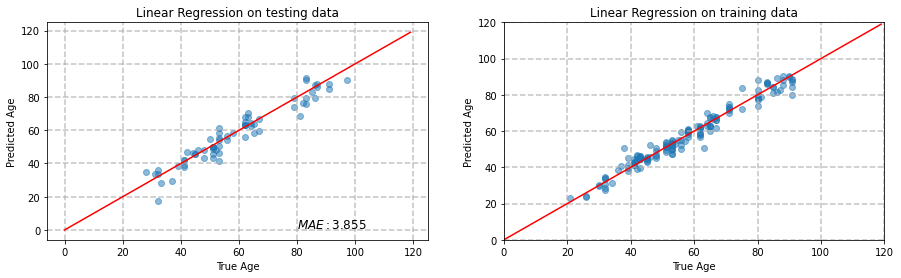

The rms on the training data is 3.318 years
The rms on the testing data is 4.984 years
The r^2 on the training data is 0.963
The r^2 on the testing data is 0.919


In [28]:
mod_55_brain_hunt=linear_regress(X_train_hunt, X_held_out_hunt, Y_train_hunt, Y_held_out_hunt,xmin=0,xmax=120)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


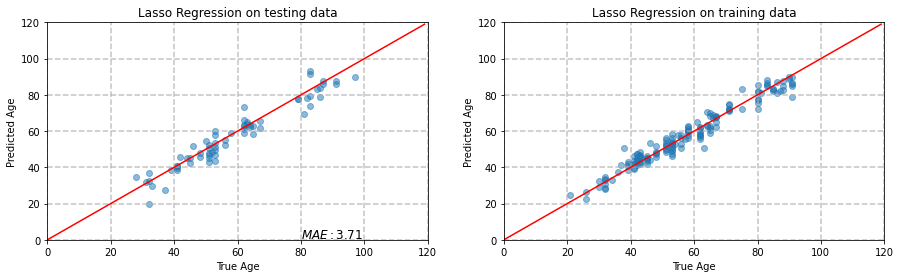

The rms on the training data is 3.650 years
The rms on the testing data is 4.880 years
The r^2 on the training data is 0.955
The r^2 on the testing data is 0.922


In [29]:
hunt_lasso=lassoCV_regress(X_train_hunt, X_held_out_hunt, Y_train_hunt, Y_held_out_hunt,xmin=0,xmax=120)

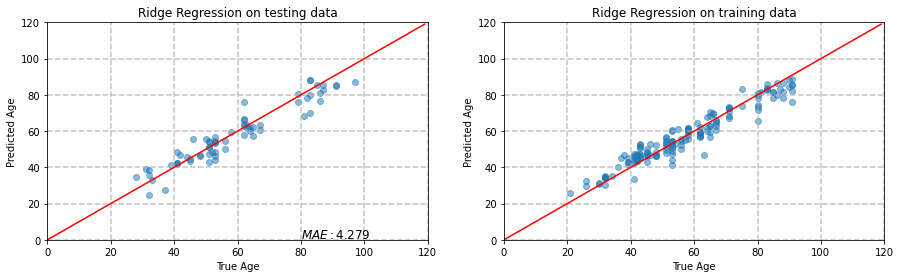

The rms on the training data is 4.819 years
The rms on the testing data is 5.432 years
The r^2 on the training data is 0.921
The r^2 on the testing data is 0.904


In [30]:
hunt_ridge=ridge_regress(X_train_hunt, X_held_out_hunt, Y_train_hunt, Y_held_out_hunt,xmin=0,xmax=120)

### Applying unhealthy model to healthy

In [31]:
X_healthy_hunt = healthy_huntingtons_df.iloc[:, 1:]
y_healthy_hunt = healthy_huntingtons_df[['AGE']]
X_healthy_hunt = mean_impute(X_healthy_hunt)

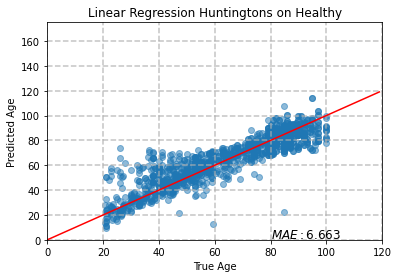

rMSE:9.310 years
r^2:0.804


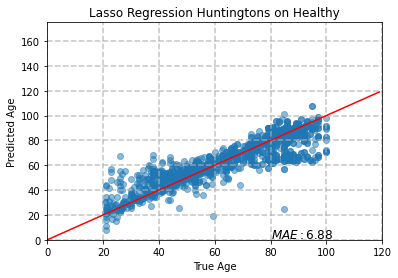

rMSE:9.741 years
r^2:0.785


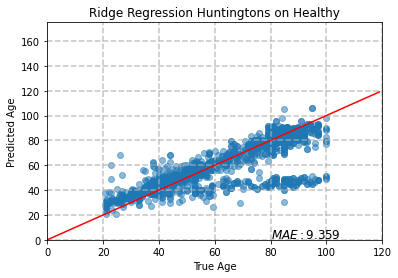

rMSE:14.631 years
r^2:0.515


In [32]:
apply_model_and_plot(mod_55_brain_hunt,X_healthy_hunt,y_healthy_hunt,'Linear Regression Huntingtons','Healthy')
apply_model_and_plot(hunt_lasso,X_healthy_hunt,y_healthy_hunt,'Lasso Regression Huntingtons','Healthy')
apply_model_and_plot(hunt_ridge,X_healthy_hunt,y_healthy_hunt,'Ridge Regression Huntingtons','Healthy')

### Classification

- Using Alzheimer's model residuals to classify healthy vs. Alzheimers

In [33]:
#Adding status columns
healthy_alzheimers_df['status']=[0]*len(list(healthy_alzheimers_df.index))
alzheimers_df['status']=[1]*len(list(alzheimers_df.index))

In [34]:
#Re-ordering columns
healthy_alzheimers_df=healthy_alzheimers_df[['status', 'AGE']+list(healthy_alzheimers_df.columns)[1:-1]]

In [35]:
healthy_alzheimers_df

,status,AGE,cg01066472,cg17104258,cg20144008,cg27009691,cg06782035,cg13954457,cg26600753,cg16875032,...,cg04897644,cg11236550,cg15393490,cg15731815,cg17801546,cg23813012,cg25139493,cg01812045,cg21182694,cg00760935
GSM2139432,0,71.0000,0.331,0.106,0.313,0.604,0.087,0.071,0.869,0.250,...,0.676,0.106,0.226,0.139,0.157,0.194,0.090,0.237,0.240,0.248
GSM2139249,0,76.0000,0.378,0.101,0.352,0.597,0.090,0.105,0.766,0.297,...,0.695,0.087,0.235,0.124,0.162,0.175,0.066,0.230,0.215,0.245
GSM1069208,0,40.0000,0.452,0.250,0.209,0.707,0.057,0.046,0.780,0.353,...,0.801,0.314,0.271,0.057,0.338,0.089,0.047,0.238,0.193,0.276
GSM1443489,0,40.0000,0.452,0.250,0.209,0.707,0.057,0.046,0.780,0.353,...,0.801,0.314,0.271,0.057,0.338,0.089,0.047,0.238,0.193,0.276
GSM1069141,0,59.0000,0.358,0.096,0.216,0.714,0.073,0.049,0.821,0.277,...,0.697,0.082,0.301,0.098,0.143,0.111,0.060,0.239,0.219,0.252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM1871753,0,53.0000,0.498,0.216,0.572,0.748,0.057,0.062,0.863,0.429,...,0.934,0.168,0.218,0.073,0.224,0.103,0.040,0.227,0.201,0.295
GSM1438255,0,53.1594,0.510,0.289,0.403,0.748,0.088,0.034,0.794,0.273,...,0.741,0.237,0.333,0.050,0.280,0.071,0.036,0.201,0.172,0.274
GSM1438138,0,53.3855,0.329,0.292,0.426,0.702,0.149,0.104,0.841,0.032,...,0.738,0.209,0.254,0.094,0.305,0.134,0.061,0.232,0.188,0.273
GSM1438147,0,53.4770,0.466,0.196,0.384,0.727,0.192,0.070,0.840,0.372,...,0.881,0.192,0.321,0.095,0.272,0.155,0.048,0.268,0.220,0.334


In [36]:
alzheimers_df=alzheimers_df[['status', 'AGE']+list(alzheimers_df.columns)[1:-1]]
alzheimers_df

,status,AGE,cg01066472,cg17104258,cg20144008,cg27009691,cg06782035,cg13954457,cg26600753,cg16875032,...,cg04897644,cg11236550,cg15393490,cg15731815,cg17801546,cg23813012,cg25139493,cg01812045,cg21182694,cg00760935
GSM1068826,1,88.0,0.512,0.010,0.165,0.648,0.035,0.024,0.906,0.011,...,0.782,0.026,0.065,0.169,0.013,0.041,0.082,0.267,0.243,0.174
GSM1068827,1,92.0,0.519,0.015,0.198,0.584,0.033,0.022,0.937,0.011,...,0.770,0.019,0.064,0.187,0.018,0.040,0.108,0.248,0.265,0.201
GSM1068829,1,93.0,0.620,0.024,0.232,0.635,0.031,0.020,0.904,0.164,...,0.859,0.028,0.068,0.226,0.025,0.052,0.063,0.264,0.329,0.238
GSM1068832,1,96.0,0.549,0.019,0.257,0.673,0.034,0.014,0.926,0.179,...,0.860,0.040,0.036,0.187,0.019,0.036,0.045,0.251,0.317,0.121
GSM1068833,1,86.0,0.287,0.021,0.196,0.633,NaN,0.022,0.928,0.224,...,0.735,0.028,0.053,0.125,0.016,0.051,0.061,0.219,0.236,0.209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM2809060,1,80.0,0.635,0.189,0.288,0.674,0.213,0.060,0.857,0.318,...,0.860,0.083,0.127,0.134,0.184,0.158,0.081,0.223,0.184,0.302
GSM2809061,1,70.0,0.520,0.394,0.303,0.685,0.103,0.072,0.725,0.270,...,0.710,0.268,0.213,0.137,0.373,0.144,0.069,0.179,0.214,0.223
GSM2809062,1,75.0,0.321,0.134,0.285,0.696,0.076,0.086,0.817,0.440,...,0.790,0.054,0.204,0.087,0.138,0.136,0.067,0.216,0.209,0.239
GSM2809063,1,79.0,0.537,0.143,0.277,0.693,0.101,0.074,0.842,0.386,...,0.835,0.068,0.147,0.137,0.161,0.211,0.092,0.232,0.220,0.309


In [37]:
#Producing a combined DF
frames=[healthy_alzheimers_df,alzheimers_df]
alzheimers_classification_df = pd.concat(frames)
alzheimers_classification_df

,status,AGE,cg01066472,cg17104258,cg20144008,cg27009691,cg06782035,cg13954457,cg26600753,cg16875032,...,cg04897644,cg11236550,cg15393490,cg15731815,cg17801546,cg23813012,cg25139493,cg01812045,cg21182694,cg00760935
GSM2139432,0,71.0,0.331,0.106,0.313,0.604,0.087,0.071,0.869,0.250,...,0.676,0.106,0.226,0.139,0.157,0.194,0.090,0.237,0.240,0.248
GSM2139249,0,76.0,0.378,0.101,0.352,0.597,0.090,0.105,0.766,0.297,...,0.695,0.087,0.235,0.124,0.162,0.175,0.066,0.230,0.215,0.245
GSM1069208,0,40.0,0.452,0.250,0.209,0.707,0.057,0.046,0.780,0.353,...,0.801,0.314,0.271,0.057,0.338,0.089,0.047,0.238,0.193,0.276
GSM1443489,0,40.0,0.452,0.250,0.209,0.707,0.057,0.046,0.780,0.353,...,0.801,0.314,0.271,0.057,0.338,0.089,0.047,0.238,0.193,0.276
GSM1069141,0,59.0,0.358,0.096,0.216,0.714,0.073,0.049,0.821,0.277,...,0.697,0.082,0.301,0.098,0.143,0.111,0.060,0.239,0.219,0.252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM2809060,1,80.0,0.635,0.189,0.288,0.674,0.213,0.060,0.857,0.318,...,0.860,0.083,0.127,0.134,0.184,0.158,0.081,0.223,0.184,0.302
GSM2809061,1,70.0,0.520,0.394,0.303,0.685,0.103,0.072,0.725,0.270,...,0.710,0.268,0.213,0.137,0.373,0.144,0.069,0.179,0.214,0.223
GSM2809062,1,75.0,0.321,0.134,0.285,0.696,0.076,0.086,0.817,0.440,...,0.790,0.054,0.204,0.087,0.138,0.136,0.067,0.216,0.209,0.239
GSM2809063,1,79.0,0.537,0.143,0.277,0.693,0.101,0.074,0.842,0.386,...,0.835,0.068,0.147,0.137,0.161,0.211,0.092,0.232,0.220,0.309


In [38]:
#Adding residual values

In [39]:
X = mean_impute(alzheimers_classification_df.iloc[:, 2:])
y = alzheimers_classification_df.iloc[:, 1]
pred = alz_ridge.predict(X)
res=pred.reshape((1,pred.shape[0]))-y.values

In [40]:
alzheimers_classification_df['alz_residuals']=res[0]

In [41]:
alzheimers_classification_df

,status,AGE,cg01066472,cg17104258,cg20144008,cg27009691,cg06782035,cg13954457,cg26600753,cg16875032,...,cg11236550,cg15393490,cg15731815,cg17801546,cg23813012,cg25139493,cg01812045,cg21182694,cg00760935,alz_residuals
GSM2139432,0,71.0,0.331,0.106,0.313,0.604,0.087,0.071,0.869,0.250,...,0.106,0.226,0.139,0.157,0.194,0.090,0.237,0.240,0.248,9.378288
GSM2139249,0,76.0,0.378,0.101,0.352,0.597,0.090,0.105,0.766,0.297,...,0.087,0.235,0.124,0.162,0.175,0.066,0.230,0.215,0.245,2.804980
GSM1069208,0,40.0,0.452,0.250,0.209,0.707,0.057,0.046,0.780,0.353,...,0.314,0.271,0.057,0.338,0.089,0.047,0.238,0.193,0.276,23.166415
GSM1443489,0,40.0,0.452,0.250,0.209,0.707,0.057,0.046,0.780,0.353,...,0.314,0.271,0.057,0.338,0.089,0.047,0.238,0.193,0.276,23.166415
GSM1069141,0,59.0,0.358,0.096,0.216,0.714,0.073,0.049,0.821,0.277,...,0.082,0.301,0.098,0.143,0.111,0.060,0.239,0.219,0.252,14.524626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM2809060,1,80.0,0.635,0.189,0.288,0.674,0.213,0.060,0.857,0.318,...,0.083,0.127,0.134,0.184,0.158,0.081,0.223,0.184,0.302,5.866463
GSM2809061,1,70.0,0.520,0.394,0.303,0.685,0.103,0.072,0.725,0.270,...,0.268,0.213,0.137,0.373,0.144,0.069,0.179,0.214,0.223,-2.417648
GSM2809062,1,75.0,0.321,0.134,0.285,0.696,0.076,0.086,0.817,0.440,...,0.054,0.204,0.087,0.138,0.136,0.067,0.216,0.209,0.239,2.316862
GSM2809063,1,79.0,0.537,0.143,0.277,0.693,0.101,0.074,0.842,0.386,...,0.068,0.147,0.137,0.161,0.211,0.092,0.232,0.220,0.309,7.829867


In [43]:
#Reading in test/train split IDs for healthy 
with open(r"../train_test_ids/brain_working_sample_ids", "rb") as input_file:
    brain_hc_working_ids = cPickle.load(input_file)
with open(r"../train_test_ids/brain_saved_sample_ids", "rb") as input_file:
    brain_hc_held_out_ids = cPickle.load(input_file)

In [44]:
#Getting working and heldout dataframes 
alz_classification_working=alzheimers_classification_df
alz_classification_heldout=alzheimers_classification_df
all_alz_class_id=list(alzheimers_classification_df.index)
for i in all_alz_class_id:
    if i not in brain_alz_working_ids and i not in brain_hc_working_ids:
        alz_classification_working=alz_classification_working.drop([i])
    if i not in brain_alz_held_out_ids and i not in brain_hc_held_out_ids:
        alz_classification_heldout=alz_classification_heldout.drop([i])

In [61]:
#X and y split for working and held out data
X_hold=alz_classification_heldout.iloc[:,[1,-1]]
y_hold=alz_classification_heldout.iloc[:,0]

X_work=alz_classification_working.iloc[:,[1,-1]]
y_work=alz_classification_working.iloc[:,0]

In [62]:
#Define class accuracy function
def class_accuracy(true,pred):
    correct=0
    total=len(pred)
    for i in range(total):
        if pred[i]==true[i]:
            correct+=1
    return correct/total

In [63]:
#Working data test/train split

In [64]:
X_tr, X_tst, y_train, y_test = train_test_split(X_work, y_work, test_size=0.25,random_state=4)
X_train = mean_impute(X_tr)
X_test = mean_impute(X_tst)
model = LogisticRegression(max_iter=1000)
model.fit(X_train,y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [65]:
from sklearn.metrics import classification_report
train_acc = class_accuracy(y_train,y_train_pred)
test_acc = class_accuracy(y_test,y_test_pred)
print('Train acc = ',train_acc,' Test acc = ',test_acc)
y_hold_pred = model.predict(X_hold)
valid_acc = class_accuracy(y_hold,y_hold_pred)
print('Heldout data acc = ',valid_acc)
print('Classification report test')
print(classification_report(y_test,y_test_pred,target_names=['Healthy','Alzheimers']))
print('Classification held out data')
print(classification_report(y_hold,y_hold_pred,target_names=['Healthy','Alzheimers']))

Train acc =  0.7364685004436557  Test acc =  0.6914893617021277
Heldout data acc =  0.6966731898238747
Classification report test
              precision    recall  f1-score   support

     Healthy       0.77      0.73      0.75       238
  Alzheimers       0.57      0.62      0.60       138

    accuracy                           0.69       376
   macro avg       0.67      0.68      0.67       376
weighted avg       0.70      0.69      0.69       376

Classification held out data
              precision    recall  f1-score   support

     Healthy       0.77      0.73      0.75       317
  Alzheimers       0.59      0.64      0.62       194

    accuracy                           0.70       511
   macro avg       0.68      0.69      0.68       511
weighted avg       0.70      0.70      0.70       511



## Alzheimer's CpGs

- Classifying healthy vs Alzheimer's using the top 100 Alzheimers CpGs in healthy dataset and age

In [60]:
#X and y split for working and held out data
X_hold=alz_classification_heldout.iloc[:,1:-1]
y_hold=alz_classification_heldout.iloc[:,0]

X_work=alz_classification_working.iloc[:,1:-1]
y_work=alz_classification_working.iloc[:,0]

In [66]:
#result_final=mean_impute(result)
X_tr, X_tst, y_train, y_test = train_test_split(X_work, y_work, test_size=0.25,random_state=4)
X_train = mean_impute(X_tr)
X_test = mean_impute(X_tst)
model = LogisticRegression(max_iter=1000)
model.fit(X_train,y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [67]:
from sklearn.metrics import classification_report
train_acc = class_accuracy(y_train,y_train_pred)
test_acc = class_accuracy(y_test,y_test_pred)
print('Train acc = ',train_acc,' Test acc = ',test_acc)
y_hold_pred = model.predict(X_hold)
valid_acc = class_accuracy(y_hold,y_hold_pred)
print('Heldout data acc = ',valid_acc)
print('Classification report test')
print(classification_report(y_test,y_test_pred,target_names=['Healthy','Alzheimers']))
print('Classification held out data')
print(classification_report(y_hold,y_hold_pred,target_names=['Healthy','Alzheimers']))

Train acc =  0.7364685004436557  Test acc =  0.6914893617021277
Heldout data acc =  0.6966731898238747
Classification report test
              precision    recall  f1-score   support

     Healthy       0.77      0.73      0.75       238
  Alzheimers       0.57      0.62      0.60       138

    accuracy                           0.69       376
   macro avg       0.67      0.68      0.67       376
weighted avg       0.70      0.69      0.69       376

Classification held out data
              precision    recall  f1-score   support

     Healthy       0.77      0.73      0.75       317
  Alzheimers       0.59      0.64      0.62       194

    accuracy                           0.70       511
   macro avg       0.68      0.69      0.68       511
weighted avg       0.70      0.70      0.70       511

